In [2]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot as plt

In [3]:
def discriminator(in_shape = (28, 28, 1)):
  model = Sequential()
  model.add(Conv2D(64, (3,3), strides = (2,2), padding = 'same', input_shape = in_shape))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dropout(0, 4))
  model.add(Conv2D(64, (3,3), strides = (2,2), padding = 'same'))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dropout(0, 4))
  model.add(Flatten())
  model.add(Dense(1, activation = 'sigmoid'))

  optimizer = Adam(lr = 0.0002, beta_1 = 0.5)
  model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])
  return model

In [4]:
def generator(latent_dim):
  model = Sequential()
  n_nodes = 128*7*7
  model.add(Dense(n_nodes, input_dim = latent_dim))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Reshape((7, 7, 128)))

  #Upsample to 14x14
  model.add(Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'))
  model.add(LeakyReLU(alpha = 0.2))

  #Upsample to 28x28
  model.add(Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'))
  model.add(LeakyReLU(alpha = 0.2))

  model.add(Conv2D(1, (7,7), activation = 'sigmoid', padding = 'same'))
  return model

In [5]:
def gan(g_model, d_model):
  d_model.trainable = False
  model = Sequential()
  model.add(g_model)
  model.add(d_model)
  opt = Adam(lr = 0.0002, beta_1 = 0.5)
  model.compile(loss = 'binary_crossentropy', optimizer = opt)
  return model

In [6]:
def load_real_samples():
  (trainX, _), (_, _) = load_data()
  X = expand_dims(trainX, axis = -1)
  X = X.astype('float32')
  X = X/255.0
  return X

In [7]:
def generate_real_samples(dataset, n_samples):
  ix = randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  Y = ones((n_samples, 1))
  return X, Y

In [8]:
def generate_latent_points(latent_dim, n_samples):
  x_input = randn(latent_dim, n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [9]:
def generate_fake_samples(g_model, latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)
  X = g_model.predict(x_input)
  Y = zeros((n_samples, 1))
  return X, Y

In [19]:
def save_plot(examples, epoch, n = 10):
  for i in range(n**2):
    plt.subplot(n, n, i+1)
    plt.axis('off')
    plt.imshow(examples[i, :, :, 0], cmap = 'gray_r')
    filename = 'generated_plot'
    plt.savefig(filename)
    plt.close()

In [20]:
def summarise_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples = 100):
  x_real, y_real = generate_real_samples(dataset, n_samples)
  _, acc_real = d_model.evaluate(x_real, y_real, verbose = 0)

  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose = 0)

  print(f"Accuracy Real - {(acc_real * 100)}, Accuracy Fake - {(acc_fake * 100)}")

  save_plot(x_fake, epoch)

  filename = 'generated_model' 
  g_model.save(filename)

In [24]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs = 5, n_batch = 256):
  batch_per_epoch = int(dataset.shape[0]/ n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    for j in range(batch_per_epoch):
      x_real, y_real = generate_real_samples(dataset, half_batch)
      x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      x, y = vstack((x_real, x_fake)), vstack((y_real, y_fake))
      d_loss, _ = d_model.train_on_batch(x, y)

      x_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(x_gan, y_gan)

      print(">%d, %d/%d, d=%.3f, g=%.3f" % (i+1, j+1, batch_per_epoch, d_loss, g_loss))
    summarise_performance(i, g_model, d_model, dataset, latent_dim)

In [22]:
latent_dim = 100
d_model = discriminator()
g_model = generator(latent_dim)
gan_model = gan(g_model, d_model)
dataset = load_real_samples()

In [25]:
train(g_model, d_model, gan_model, dataset, latent_dim)

4/4 [==============================] - 1s 172ms/step
>1, 1/234, d=0.659, g=0.792
4/4 [==============================] - 1s 171ms/step
>1, 2/234, d=0.650, g=0.810
4/4 [==============================] - 1s 280ms/step
>1, 3/234, d=0.644, g=0.826
4/4 [==============================] - 1s 168ms/step
>1, 4/234, d=0.638, g=0.840
4/4 [==============================] - 1s 167ms/step
>1, 5/234, d=0.633, g=0.850
4/4 [==============================] - 1s 275ms/step
>1, 6/234, d=0.631, g=0.854
4/4 [==============================] - 1s 163ms/step
>1, 7/234, d=0.628, g=0.851
4/4 [==============================] - 1s 172ms/step
>1, 8/234, d=0.630, g=0.839
4/4 [==============================] - 1s 169ms/step
>1, 9/234, d=0.633, g=0.818
4/4 [==============================] - 1s 165ms/step
>1, 10/234, d=0.637, g=0.791
4/4 [==============================] - 1s 167ms/step
>1, 11/234, d=0.643, g=0.767
4/4 [==============================] - 1s 173ms/step
>1, 12/234, d=0.643, g=0.747
4/4 [====================

4/4 [==============================] - 1s 170ms/step
>2, 1/234, d=0.654, g=0.926
4/4 [==============================] - 1s 168ms/step
>2, 2/234, d=0.700, g=0.890
4/4 [==============================] - 1s 254ms/step
>2, 3/234, d=0.686, g=0.837
4/4 [==============================] - 1s 174ms/step
>2, 4/234, d=0.735, g=0.868
4/4 [==============================] - 1s 175ms/step
>2, 5/234, d=0.762, g=0.893
4/4 [==============================] - 1s 274ms/step
>2, 6/234, d=0.791, g=0.900
4/4 [==============================] - 1s 170ms/step
>2, 7/234, d=0.782, g=0.916
4/4 [==============================] - 1s 172ms/step
>2, 8/234, d=0.830, g=0.912
4/4 [==============================] - 1s 264ms/step
>2, 9/234, d=0.794, g=0.907
4/4 [==============================] - 1s 175ms/step
>2, 10/234, d=0.782, g=0.907
4/4 [==============================] - 1s 169ms/step
>2, 11/234, d=0.788, g=0.910
4/4 [==============================] - 1s 187ms/step
>2, 12/234, d=0.759, g=0.899
4/4 [====================

4/4 [==============================] - 1s 176ms/step
>3, 1/234, d=0.710, g=0.704
4/4 [==============================] - 1s 173ms/step
>3, 2/234, d=0.705, g=0.722
4/4 [==============================] - 1s 167ms/step
>3, 3/234, d=0.708, g=0.716
4/4 [==============================] - 1s 169ms/step
>3, 4/234, d=0.716, g=0.716
4/4 [==============================] - 1s 180ms/step
>3, 5/234, d=0.717, g=0.707
4/4 [==============================] - 1s 173ms/step
>3, 6/234, d=0.713, g=0.728
4/4 [==============================] - 1s 175ms/step
>3, 7/234, d=0.719, g=0.726
4/4 [==============================] - 1s 171ms/step
>3, 8/234, d=0.715, g=0.726
4/4 [==============================] - 1s 171ms/step
>3, 9/234, d=0.710, g=0.704
4/4 [==============================] - 1s 175ms/step
>3, 10/234, d=0.714, g=0.724
4/4 [==============================] - 1s 171ms/step
>3, 11/234, d=0.714, g=0.713
4/4 [==============================] - 1s 175ms/step
>3, 12/234, d=0.717, g=0.733
4/4 [====================

4/4 [==============================] - 1s 171ms/step
>4, 1/234, d=0.707, g=0.738
4/4 [==============================] - 1s 173ms/step
>4, 2/234, d=0.714, g=0.752
4/4 [==============================] - 1s 172ms/step
>4, 3/234, d=0.700, g=0.749
4/4 [==============================] - 1s 178ms/step
>4, 4/234, d=0.709, g=0.738
4/4 [==============================] - 1s 196ms/step
>4, 5/234, d=0.713, g=0.713
4/4 [==============================] - 1s 172ms/step
>4, 6/234, d=0.717, g=0.736
4/4 [==============================] - 1s 174ms/step
>4, 7/234, d=0.726, g=0.728
4/4 [==============================] - 1s 174ms/step
>4, 8/234, d=0.721, g=0.724
4/4 [==============================] - 1s 170ms/step
>4, 9/234, d=0.726, g=0.715
4/4 [==============================] - 1s 169ms/step
>4, 10/234, d=0.707, g=0.712
4/4 [==============================] - 1s 176ms/step
>4, 11/234, d=0.713, g=0.717
4/4 [==============================] - 1s 172ms/step
>4, 12/234, d=0.691, g=0.742
4/4 [====================

4/4 [==============================] - 1s 181ms/step
>5, 1/234, d=0.710, g=0.751
4/4 [==============================] - 1s 171ms/step
>5, 2/234, d=0.717, g=0.753
4/4 [==============================] - 1s 177ms/step
>5, 3/234, d=0.717, g=0.744
4/4 [==============================] - 1s 176ms/step
>5, 4/234, d=0.712, g=0.741
4/4 [==============================] - 1s 168ms/step
>5, 5/234, d=0.718, g=0.708
4/4 [==============================] - 1s 233ms/step
>5, 6/234, d=0.714, g=0.704
4/4 [==============================] - 1s 172ms/step
>5, 7/234, d=0.714, g=0.681
4/4 [==============================] - 1s 167ms/step
>5, 8/234, d=0.714, g=0.692
4/4 [==============================] - 1s 179ms/step
>5, 9/234, d=0.713, g=0.709
4/4 [==============================] - 1s 173ms/step
>5, 10/234, d=0.714, g=0.706
4/4 [==============================] - 1s 174ms/step
>5, 11/234, d=0.720, g=0.697
4/4 [==============================] - 1s 172ms/step
>5, 12/234, d=0.712, g=0.712
4/4 [====================

In [37]:
def save_plot(examples, n):
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis("off")
    plt.imshow(examples[i, :, :, 0], cmap="gray_r")
  plt.show()
  filename = 'generated_plot'
  plt.savefig(filename)

1/1 [==============================] - 0s 170ms/step


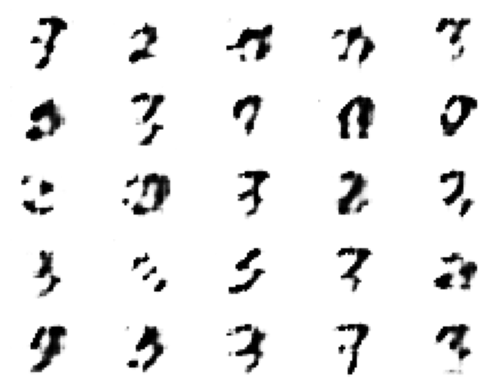

<Figure size 640x480 with 0 Axes>

In [38]:
latent_points = generate_latent_points(100, 25) 
X = g_model.predict(latent_points)
# plot the result
save_plot(X, 5)

1/1 [==============================] - 0s 39ms/step


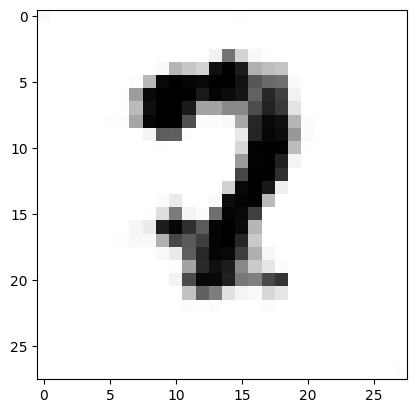

<Figure size 640x480 with 0 Axes>

In [49]:
from numpy import asarray
vector = asarray([[0.5 for _ in range(100)]])

X = g_model.predict(vector)
plt.imshow(X[0, :, :, 0], cmap = 'gray_r') 
plt.show()
filename = 'generated_plot'
plt.savefig(filename)